# hyperlinks network

In [12]:
%run "libraries.ipynb"
import os
from IPython.display import display, HTML

from bs4 import BeautifulSoup

## loading the original namespace

In order to control our namespace, we are importing [a list of wikipedia pages](https://github.com/WeKeyPedia/notebooks/blob/master/geometry/data/pagenames.txt) that we extracted from the [List of geometry topics](http://en.wikipedia.org/wiki/list_of_geometry_topics).

In [18]:
pages = codecs.open("data/pagenames.txt","r", "utf-8-sig").readlines()
pages = map(lambda x: x.strip(), pages)

## finding wikipedia links in the page content

In [19]:
hyperlinks_graph = nx.DiGraph()

def get_content(page):
    if os.path.exists("data/pages/%s.json" % (page)) == False:
        print "%s does not exist" % ("data/pages/%s.json" % (page))
        return ""
    
    with codecs.open("data/pages/%s.json" % (page), "r", "utf-8-sig") as f:
        j = json.load(f)
        content = j["query"]["pages"][j["query"]["pages"].keys()[0]]
        
        # handle pages without content
        if "revisions" in content:
            content = content["revisions"][0]["*"]
        else:
            content = ""

    return content

def find_hyperlinks(page):
    hyperlinks = []

    content = get_content(page)
    content = BeautifulSoup(content, 'html.parser') 

    hyperlinks = content.find_all('a')
        
    return hyperlinks

for p in pages:
    occurences_link = {}
    occurences_named_entity = {}

    hyperlinks = find_hyperlinks(p)
    content = u"" + get_content(p)
    # keep only title of the link
    hyperlinks = map(lambda x: x.get("title"), hyperlinks)

    # some hyperlinks have no title
    hyperlinks = [ x for x in hyperlinks if x != None ]
    
    # sorted hyperlinks by title length in order to get a more precise n-graming
    # otherwise terms like "triangle" are over-evaluated because of other terms
    # like "equilateral triangle"
    hyperlinks = sorted(hyperlinks, key=lambda k: -len(k))
    
    gruyere = content
    
    for k in hyperlinks:
        # count occurences links
        occurences_link.setdefault(k, 0)
        occurences_link[k] += 1
        
        # count occurences terms
        occurences_named_entity.setdefault(k, 0)
        occurences_named_entity[k] = unicode(gruyere).count(unicode(k))
        
        gruyere = gruyere.replace(k, "")

    # print "coverage: %s/%s (%s%%)" % (len(gruyere), len(content), float(len(gruyere))*100/float(len(content)))
    # reduce to a list of unique items
    
    hyperlinks = list(set(hyperlinks))

    # keep only linked pages that are inside the initial domain
    intradomain_pages = set(hyperlinks) & set(pages)
    extradomain_pages = set(hyperlinks) - set(pages)

#     print len( hyperlinks )
#     print len( intradomain_pages )
#     print len( extradomain_pages )
    
    for target in intradomain_pages:
        edge_info = { "link occurence": occurences_link[target], "term occurence":  occurences_named_entity[target] }
        hyperlinks_graph.add_edge(p, target, attr_dict=edge_info)

print "nodes: %s" % len(hyperlinks_graph.nodes())
print "edges: %s" % len(hyperlinks_graph.edges())

data/pages/Latino/a.json does not exist
data/pages/Latino/a.json does not exist
nodes: 1874
edges: 49496


## storing the result graph

In [20]:
nx.write_gexf(hyperlinks_graph, "data/hyperlinks.gexf")

## community detection (louvain)

In [21]:
import community
partitions = community.best_partition(hyperlinks_graph.to_undirected())

In [22]:
def print_groups(communities):
    html = "<table>"

    for c, ps in communities.iteritems():
        html += "<tr><td style=\"width: 100px; text-align: center; \"><h3>group %s</h3></td><td>" % (c)
        html += ", ".join(map(lambda x: u"<a href=\"http://en.wikipedia.org/wiki/{0}\" target=\"_blank\">{0}</a>".format(x), ps))
        html += "</td></tr>"
    
    html += "</table>"

    display(HTML(html))
        
communities = {}
for k, v in partitions.iteritems():
    communities.setdefault(v, []).append(k)

print_groups(communities)

group 0
group 1
group 2
group 3
group 4


## explore local subgraphes

In [7]:
from IPython.html import widgets
import matplotlib.patheffects as path_effects

:0: FutureWarning: IPython widgets are experimental and may change in the future.


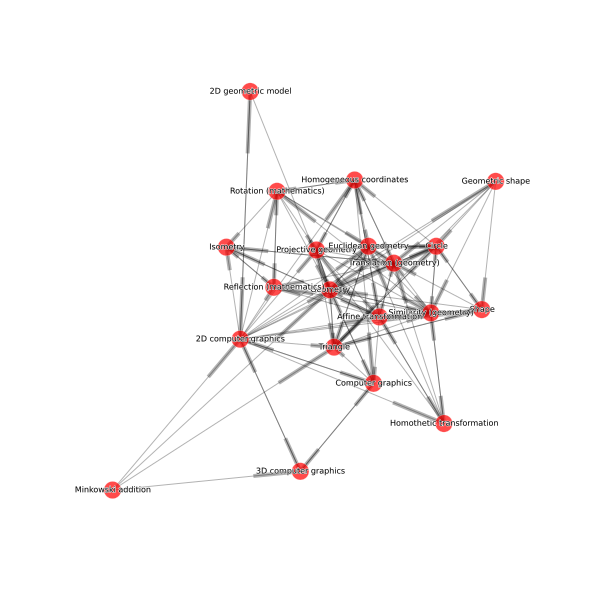

In [8]:
%config InlineBackend.figure_formats=['svg']

def display_local_graph(page):
    nbunch = [ page ]
    nbunch.extend( list(hyperlinks_graph.to_undirected()[page]))
    g = hyperlinks_graph.subgraph(nbunch)

    #nx.draw_spring(g2)
    plt
    pos = nx.spring_layout(g,iterations=150)
   
    plt.figure(figsize=(10,10))

    nodes = nx.draw_networkx_nodes(g, pos, alpha=0.7)
    nodes.set_edgecolor('w')
    nx.draw_networkx_edges(g, pos, alpha=0.3, width=1)
    labels = nx.draw_networkx_labels(g, pos, font_size=8, font_family="Bitstream Vera Sans")
    map(lambda x: labels[x].set_path_effects([path_effects.Stroke(linewidth=1, foreground='white'),
                       path_effects.Normal()]),labels)
    
    plt.axis('off')
    plt.show()


w = widgets.Select(description="page", options=pages)
widgets.interact(display_local_graph, page=w);